# 0.0. PREPARATION

## 0.1. Assumptions

Tenure -> time in months since customers joined the customer base

Balance -> amount of money spent by the customer

## 0.1. Imports

In [65]:
import pickle

import numpy   as np
import pandas  as pd
import seaborn as sns

import matplotlib.pyplot as plt

from scipy                 import stats
from xgboost               import XGBClassifier
from IPython.core.display  import HTML

from sklearn    import metrics         as mt
from sklearn    import model_selection as ms
from sklearn import preprocessing as pp
from sklearn import linear_model as lm
from sklearn import ensemble as en
from sklearn import neighbors as nh

## 0.2. Load Data

In [2]:
df_raw = pd.read_csv('../data/abandono_clientes.csv')

### 0.2.1. Split Test Data

In [3]:
df1, df_test = ms.train_test_split(df_raw, test_size=0.1)

## 0.3. Helper Functions

In [4]:
def cramer_v (x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2corr = max(0, chi2-(k-1)*(r-1)/(n-1))
    
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

def corr_cramer_v(cat_attributes):
    cat_attributes_list = cat_attributes.columns.tolist()

    corr_dict={}

    for i in range(len(cat_attributes_list)):
        corr_list=[]
        for j in range(len(cat_attributes_list)):
            ref=cat_attributes_list[i]
            feat=cat_attributes_list[j]
            corr = cramer_v(cat_attributes[ref],cat_attributes[feat])
            corr_list.append(corr)
        corr_dict[ref]= corr_list
    return corr_dict

def jupyter_settings():
    %matplotlib inline
    #%pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [5]:
jupyter_settings()

# 1.0. DATA DESCRIPTION

In [6]:
df1.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
385,386,15720910,Black,560,France,Female,66,9,0.00,1,1,1,15928.49,0
8929,8930,15675141,Fraser,569,France,Female,35,4,93934.63,1,1,0,184748.23,0
4156,4157,15599452,Conti,605,Germany,Female,43,8,125338.80,2,1,0,23970.13,0
3372,3373,15643967,Chineze,652,France,Female,37,4,92208.54,1,0,1,197699.80,1
3166,3167,15746203,Hsia,555,Germany,Male,62,4,119817.33,1,0,1,43507.10,1


## 1.1. Data Dimensions

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 9000
Number of columns: 14


## 1.2. Data Types

In [8]:
df1.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

## 1.3. Checks

In [9]:
# check na
df1.isna().sum()

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [10]:
# check duplicates
df1.duplicated().sum()

0

In [11]:
# check balance
df1['Exited'].value_counts(normalize=True)

Exited
0    0.797778
1    0.202222
Name: proportion, dtype: float64

## 1.4. Descriptive Analysis

In [12]:
df1.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
385,386,15720910,Black,560,France,Female,66,9,0.00,1,1,1,15928.49,0
8929,8930,15675141,Fraser,569,France,Female,35,4,93934.63,1,1,0,184748.23,0
4156,4157,15599452,Conti,605,Germany,Female,43,8,125338.80,2,1,0,23970.13,0
3372,3373,15643967,Chineze,652,France,Female,37,4,92208.54,1,0,1,197699.80,1
3166,3167,15746203,Hsia,555,Germany,Male,62,4,119817.33,1,0,1,43507.10,1


In [13]:
num_attributes = df1[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']]
cat_attributes = df1[['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']]

### 1.4.1. Numerical Attributes

In [14]:
# central tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# dispersion: std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(np.min)).T
d3 = pd.DataFrame(num_attributes.apply(np.max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concat metrics
num_statics = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()
num_statics.columns = ['attribute', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [15]:
num_statics

,attribute,min,max,range,mean,median,std,skew,kurtosis
0,CreditScore,350.00,850.00,500.00,651.036000,652.000,96.713745,-0.077894,-0.422450
1,Age,18.00,92.00,74.00,38.965556,37.000,10.523737,0.993996,1.321721
2,Tenure,0.00,10.00,10.00,5.024556,5.000,2.885973,0.004479,-1.162180
3,Balance,0.00,250898.09,250898.09,76625.554799,97350.825,62407.052703,-0.144832,-1.490451
4,NumOfProducts,1.00,4.00,3.00,1.528444,1.000,0.580107,0.737947,0.546069
5,EstimatedSalary,11.58,199992.48,199980.90,99975.812870,99796.845,57382.618156,0.007741,-1.175774


### 1.4.2. Categorical Attributes

In [16]:
cat_attributes.apply(lambda x: x.unique().shape[0])

Geography         3
Gender            2
HasCrCard         2
IsActiveMember    2
Exited            2
dtype: int64

# 2.0. FEATURE ENGINEERING

In [17]:
df2 = df1.copy()

In [18]:
# average ticket
df2['AvgTicket'] = np.round(df2['Balance'] / df2['NumOfProducts'], 2)

# 3.0. DATA FILTERING

In [19]:
df3 = df2.copy()

In [20]:
# drop meaningless columns
df3 = df3.drop(['RowNumber', 'Surname'], axis = 1)

# 4.0. EXPLORATORY DATA ANALYSIS

In [21]:
df4 = df3.copy()

## 4.1. Univariate Analysis

In [22]:
num_attributes = df4[['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'AvgTicket']]
cat_attributes = df4[['Geography', 'Gender', 'HasCrCard', 'IsActiveMember', 'Exited']]

### 4.1.1. Response Variable

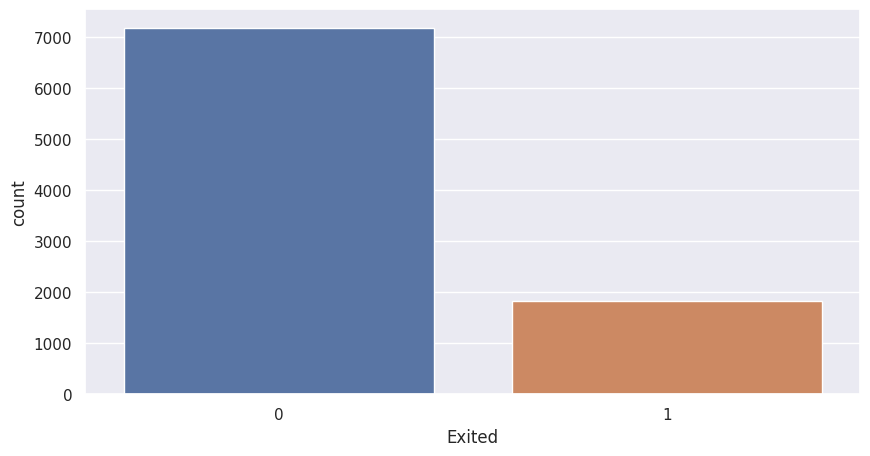

In [23]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x='Exited', data=df4);

### 4.1.2. Numerical Variables

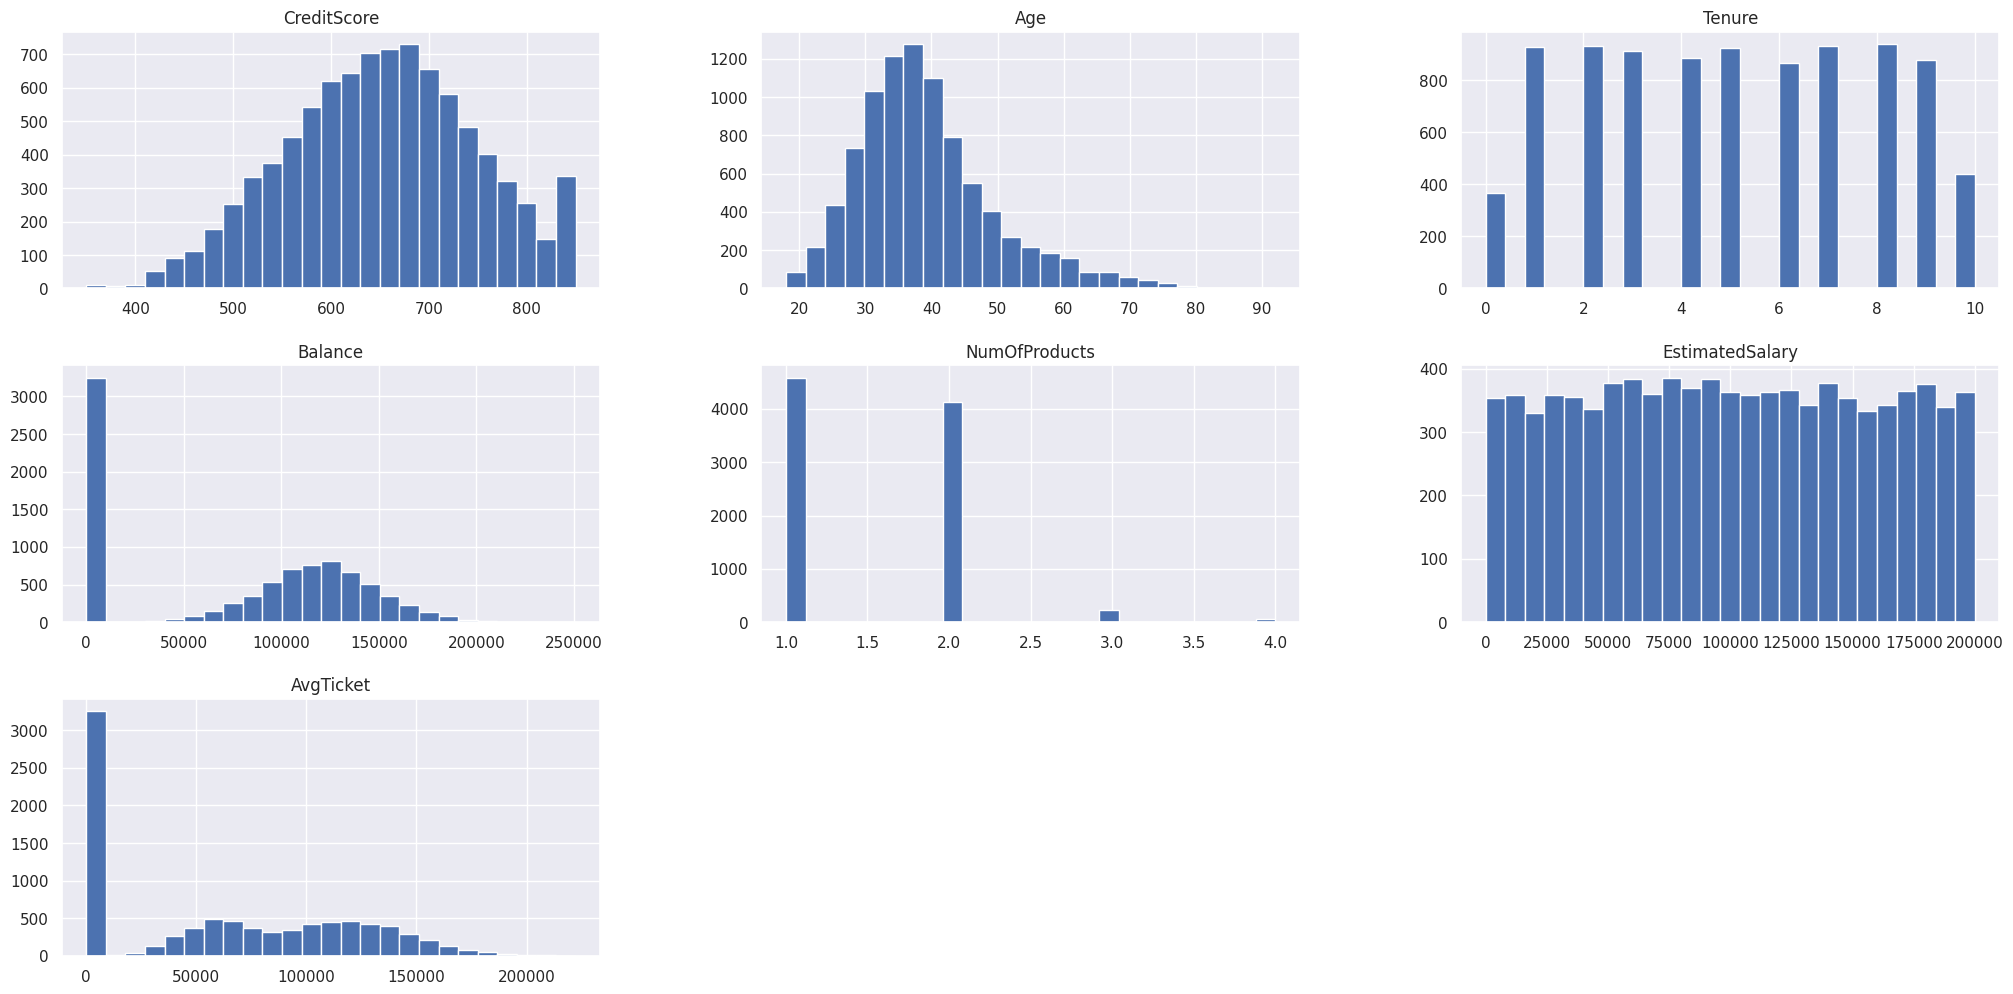

In [24]:
num_attributes.hist(bins=25);

/tmp/ipykernel_28895/2158198755.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


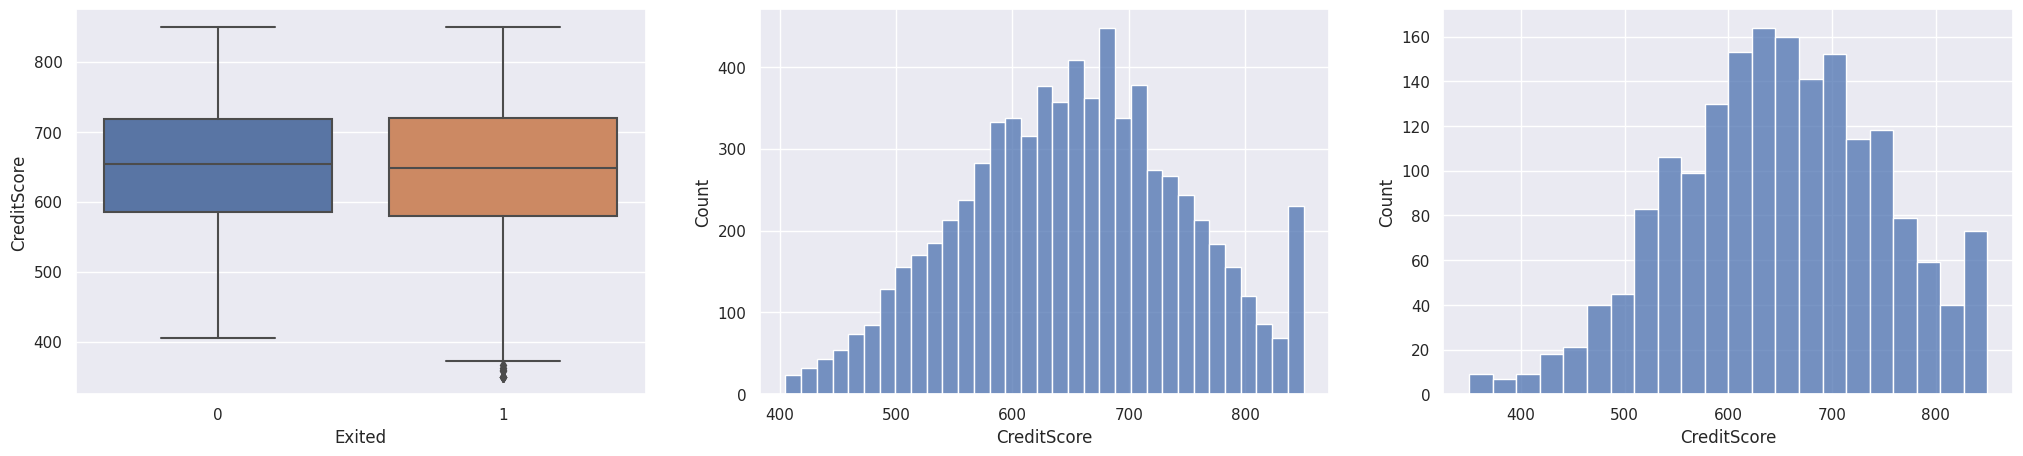

In [25]:
# Credit Score
fig, ax = plt.subplots(figsize=(25, 5))
plt.subplot(1,3,1)
sns.boxplot(x='Exited', y='CreditScore', data=df4);

plt.subplot(1,3,2)
CreditScore0 = df4.loc[df4['Exited'] == 0, 'CreditScore']
sns.histplot(CreditScore0);

plt.subplot(1,3,3)
CreditScore1 = df4.loc[df4['Exited'] == 1, 'CreditScore']
sns.histplot(CreditScore1);

/tmp/ipykernel_28895/1261668618.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


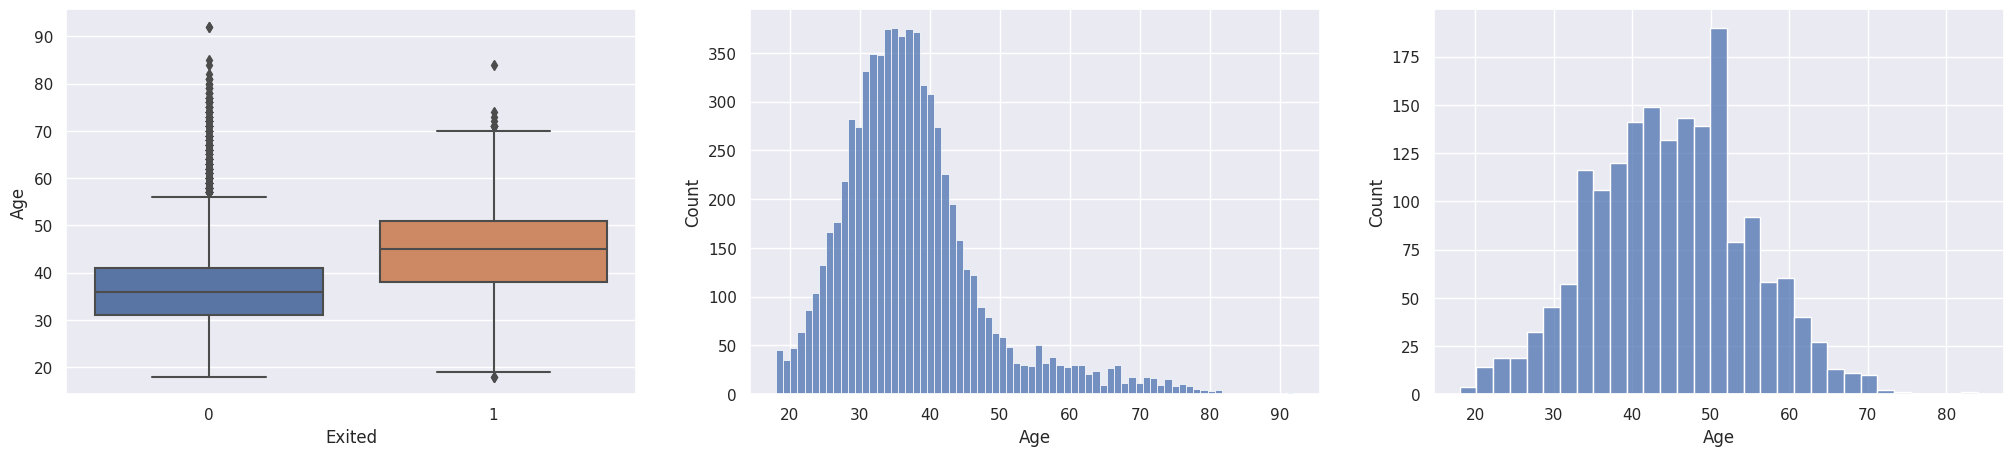

In [26]:
# Age
fig, ax = plt.subplots(figsize=(25, 5))
plt.subplot(1,3,1)
sns.boxplot(x='Exited', y='Age', data=df4);

plt.subplot(1,3,2)
Age0 = df4.loc[df4['Exited'] == 0, 'Age']
sns.histplot(Age0);

plt.subplot(1,3,3)
Age1 = df4.loc[df4['Exited'] == 1, 'Age']
sns.histplot(Age1);

/tmp/ipykernel_28895/2524579783.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


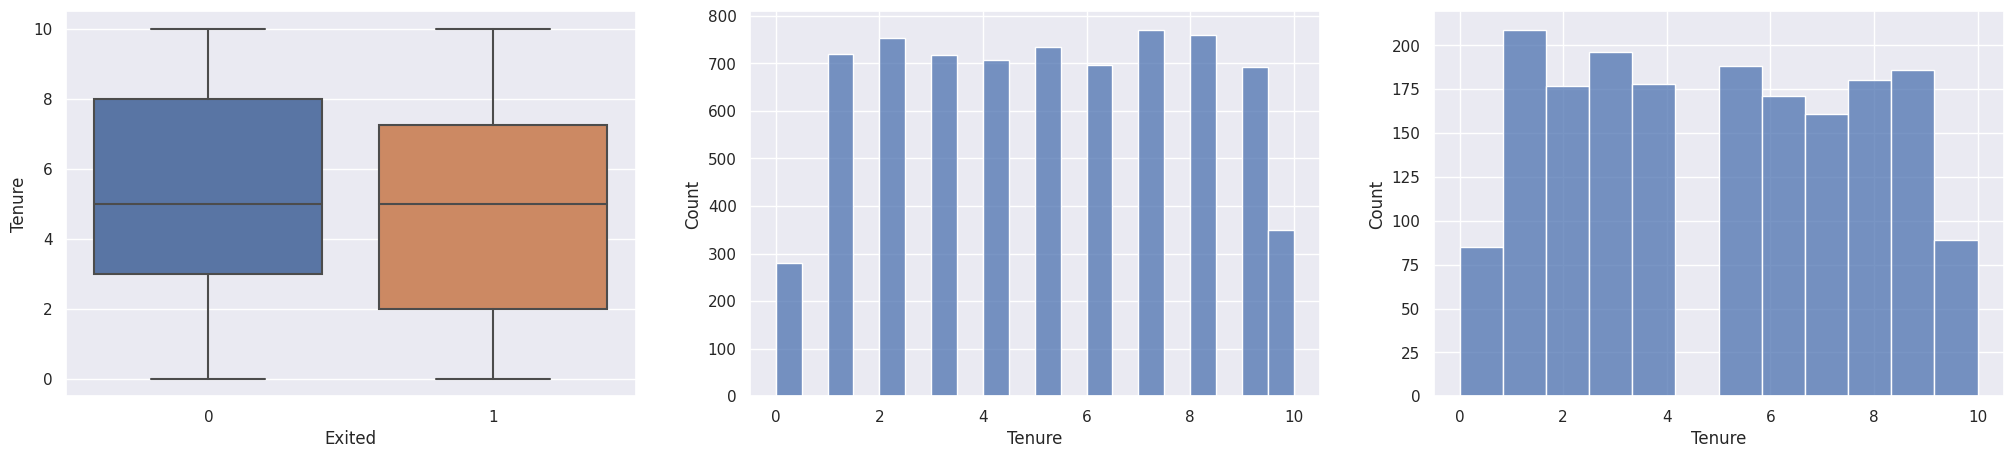

In [27]:
# Tenure
fig, ax = plt.subplots(figsize=(25, 5))
plt.subplot(1,3,1)
sns.boxplot(x='Exited', y='Tenure', data=df4);

plt.subplot(1,3,2)
Tenure0 = df4.loc[df4['Exited'] == 0, 'Tenure']
sns.histplot(Tenure0);

plt.subplot(1,3,3)
Tenure1 = df4.loc[df4['Exited'] == 1, 'Tenure']
sns.histplot(Tenure1);

/tmp/ipykernel_28895/3530946033.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


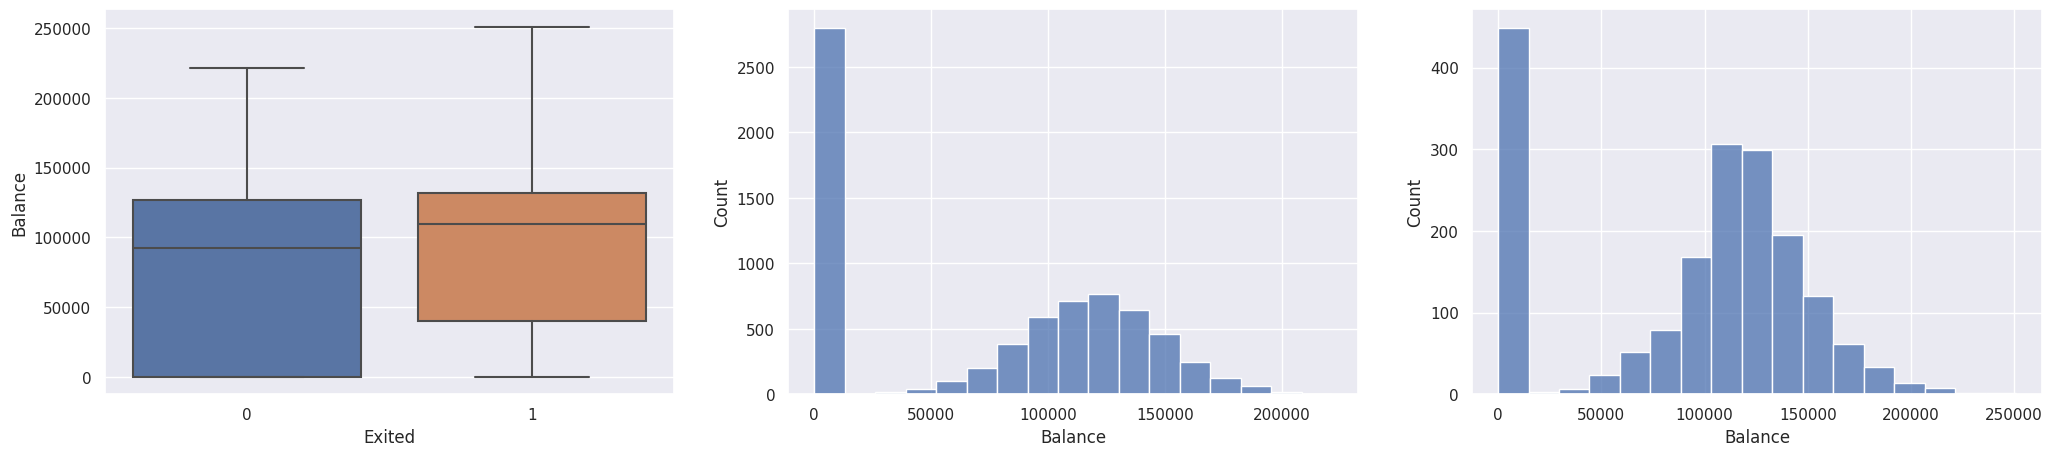

In [28]:
# Balance
fig, ax = plt.subplots(figsize=(25, 5))
plt.subplot(1,3,1)
sns.boxplot(x='Exited', y='Balance', data=df4);

plt.subplot(1,3,2)
Balance0 = df4.loc[df4['Exited'] == 0, 'Balance']
sns.histplot(Balance0);

plt.subplot(1,3,3)
Balance1 = df4.loc[df4['Exited'] == 1, 'Balance']
sns.histplot(Balance1);

/tmp/ipykernel_28895/1650660008.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


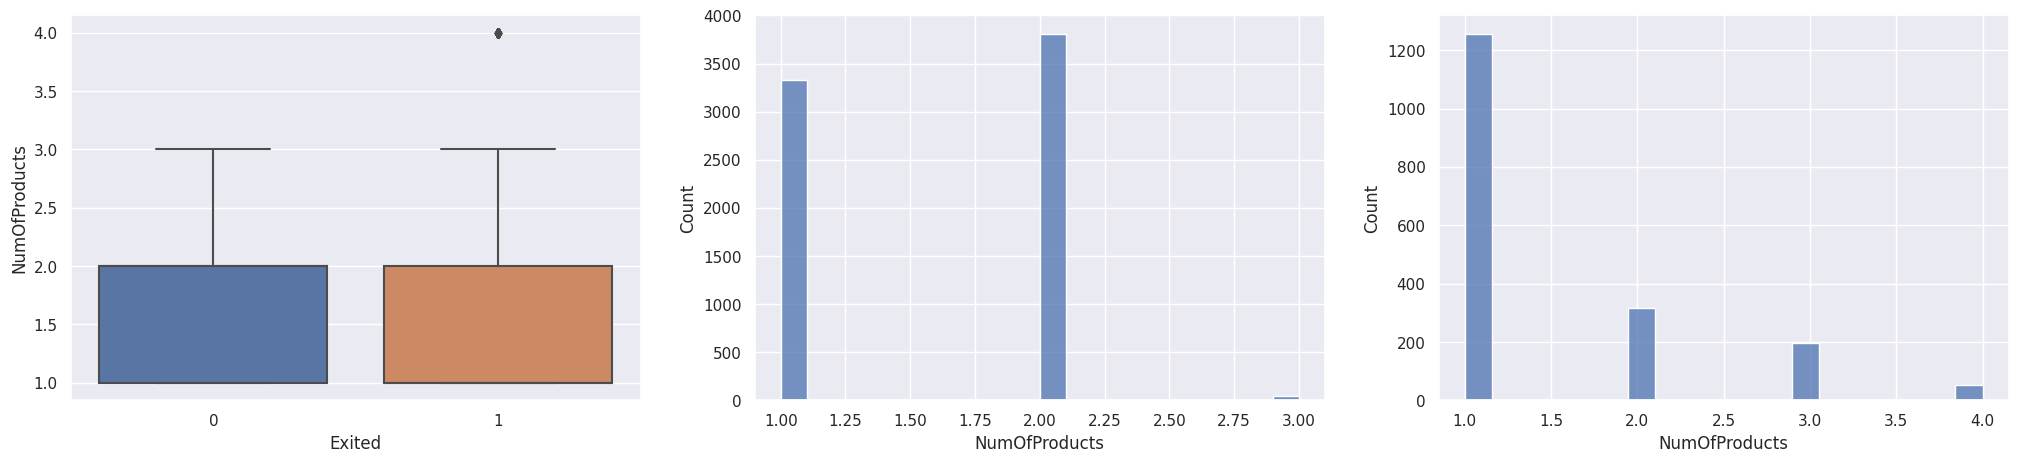

In [29]:
# NumOfProducts
fig, ax = plt.subplots(figsize=(25, 5))
plt.subplot(1,3,1)
sns.boxplot(x='Exited', y='NumOfProducts', data=df4);

plt.subplot(1,3,2)
NumOfProducts0 = df4.loc[df4['Exited'] == 0, 'NumOfProducts']
sns.histplot(NumOfProducts0);

plt.subplot(1,3,3)
NumOfProducts1 = df4.loc[df4['Exited'] == 1, 'NumOfProducts']
sns.histplot(NumOfProducts1);

/tmp/ipykernel_28895/238950735.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


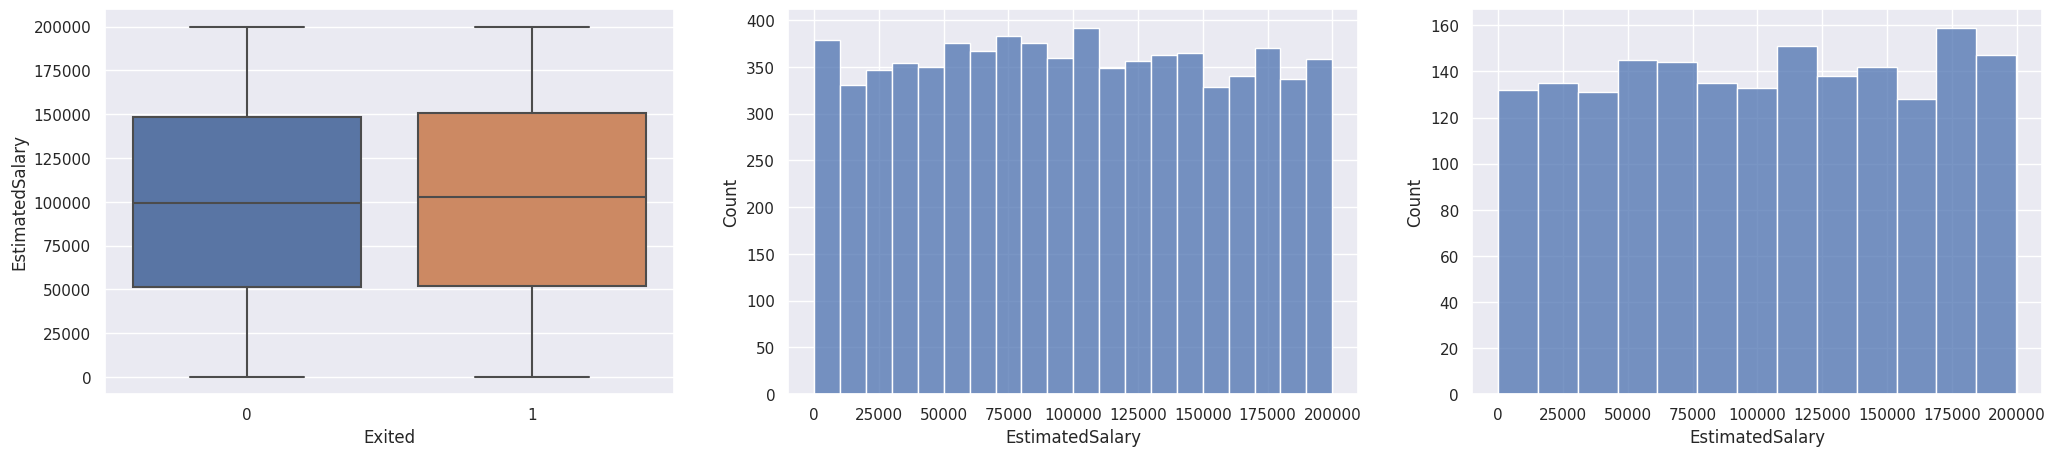

In [30]:
# EstimatedSalary
fig, ax = plt.subplots(figsize=(25, 5))
plt.subplot(1,3,1)
sns.boxplot(x='Exited', y='EstimatedSalary', data=df4);

plt.subplot(1,3,2)
EstimatedSalary0 = df4.loc[df4['Exited'] == 0, 'EstimatedSalary']
sns.histplot(EstimatedSalary0);

plt.subplot(1,3,3)
EstimatedSalary1 = df4.loc[df4['Exited'] == 1, 'EstimatedSalary']
sns.histplot(EstimatedSalary1);

/tmp/ipykernel_28895/3995312931.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,3,1)


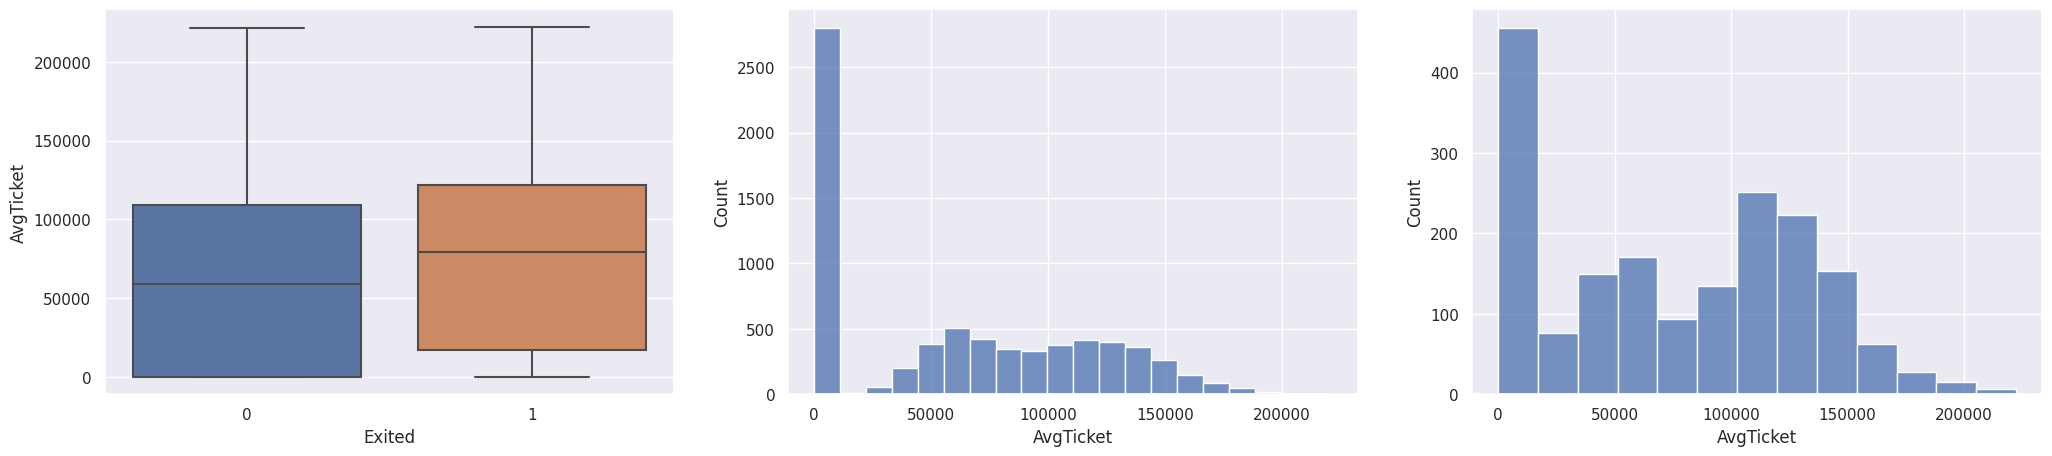

In [31]:
# AvgTicket
fig, ax = plt.subplots(figsize=(25, 5))
plt.subplot(1,3,1)
sns.boxplot(x='Exited', y='AvgTicket', data=df4);

plt.subplot(1,3,2)
AvgTicket0 = df4.loc[df4['Exited'] == 0, 'AvgTicket']
sns.histplot(AvgTicket0);

plt.subplot(1,3,3)
AvgTicket1 = df4.loc[df4['Exited'] == 1, 'AvgTicket']
sns.histplot(AvgTicket1);

### 4.1.3. Categorical Variables

In [32]:
df_churn = df4[df4['Exited'] == 1]
df_nchurn = df4[df4['Exited'] == 0]

/tmp/ipykernel_28895/710844022.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


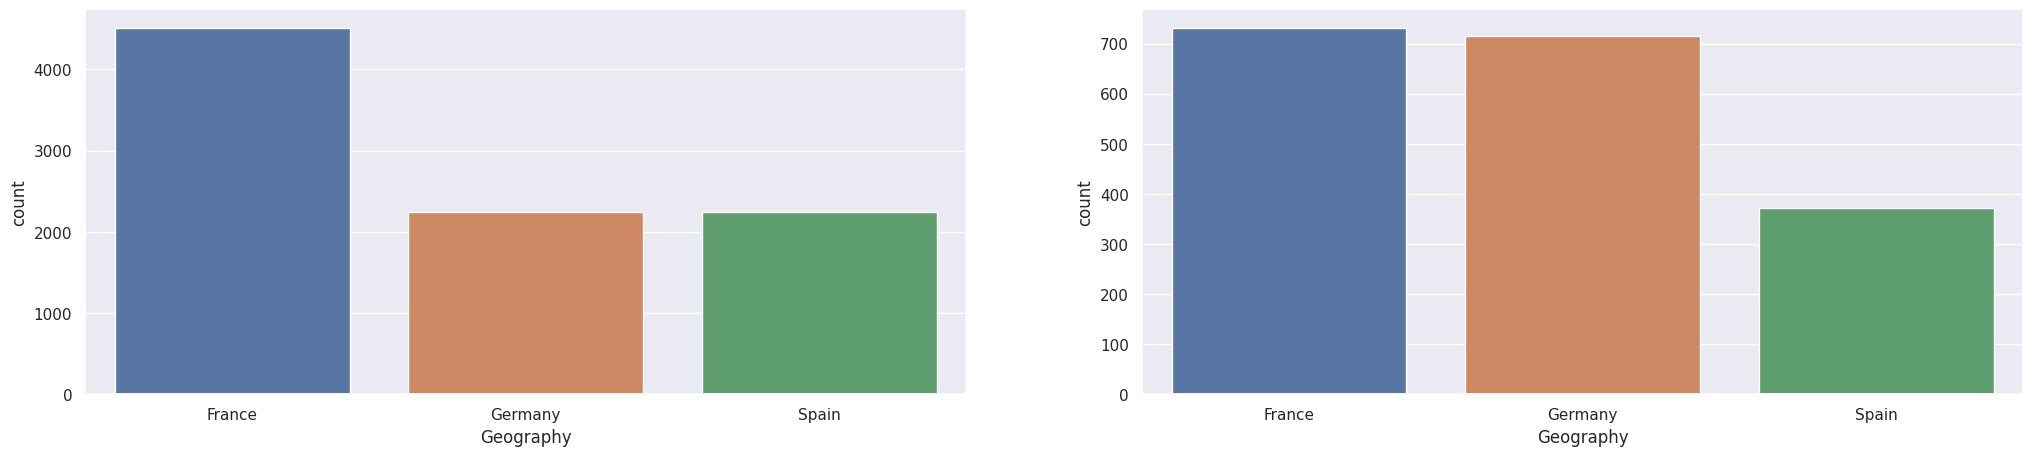

In [33]:
# geography
plt.subplots(figsize=(25, 5))
plt.subplot(1,2,1)
sns.countplot(x='Geography', data=df4);

plt.subplot(1,2,2)
sns.countplot(x='Geography', data=df_churn);

/tmp/ipykernel_28895/3242352414.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


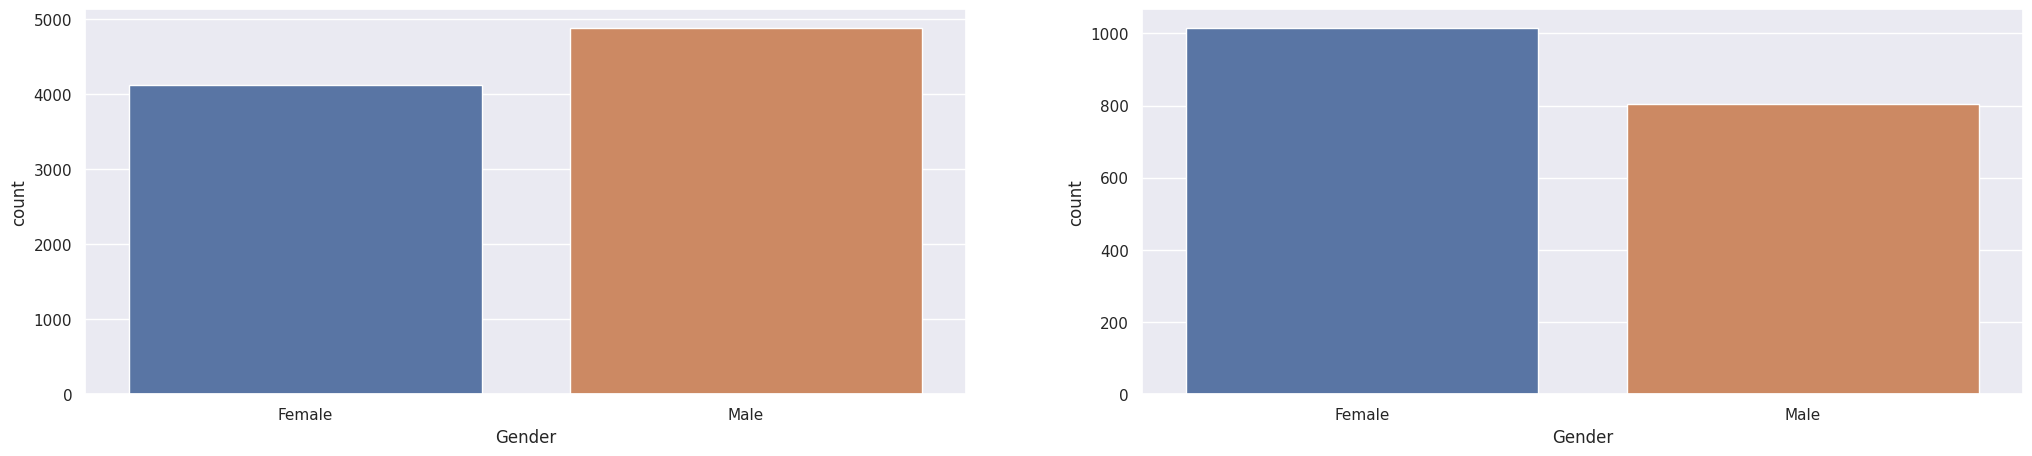

In [34]:
# gender
plt.subplots(figsize=(25, 5))
plt.subplot(1,2,1)
sns.countplot(x='Gender', data=df4);

plt.subplot(1,2,2)
sns.countplot(x='Gender', data=df_churn);

/tmp/ipykernel_28895/1413657579.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


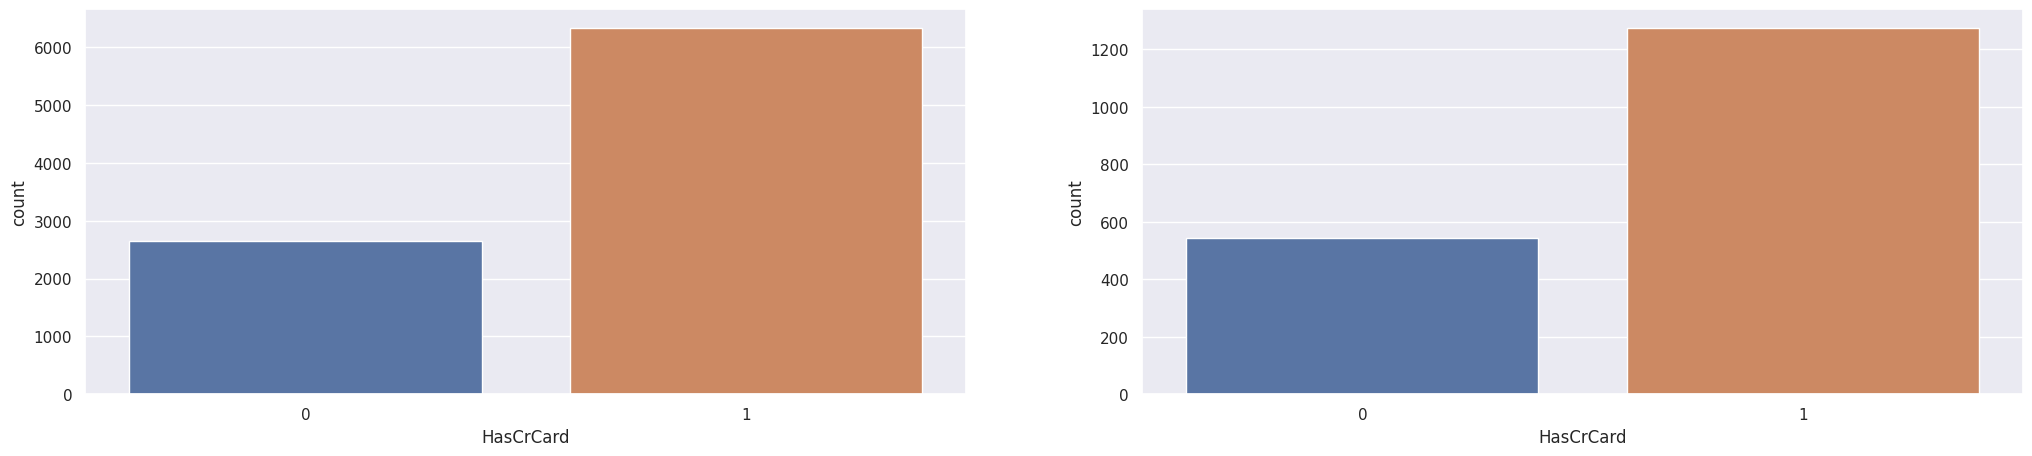

In [35]:
# has credit card
plt.subplots(figsize=(25, 5))
plt.subplot(1,2,1)
sns.countplot(x='HasCrCard', data=df4);

plt.subplot(1,2,2)
sns.countplot(x='HasCrCard', data=df_churn);

/tmp/ipykernel_28895/3152507493.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1,2,1)


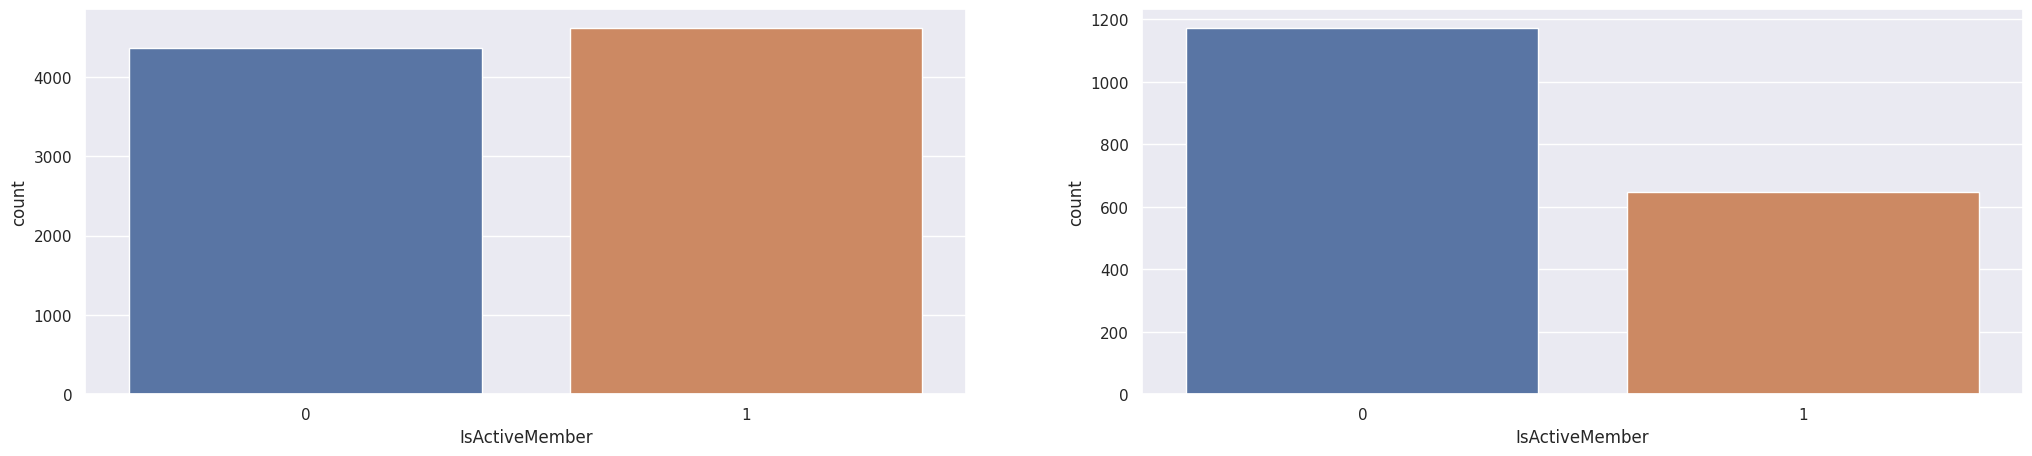

In [36]:
# is active
plt.subplots(figsize=(25, 5))
plt.subplot(1,2,1)
sns.countplot(x='IsActiveMember', data=df4);

plt.subplot(1,2,2)
sns.countplot(x='IsActiveMember', data=df_churn);

## 4.2. Bivariate Analysis

In [37]:
# create business hypotesis and validate with bivariate analysis

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Variables

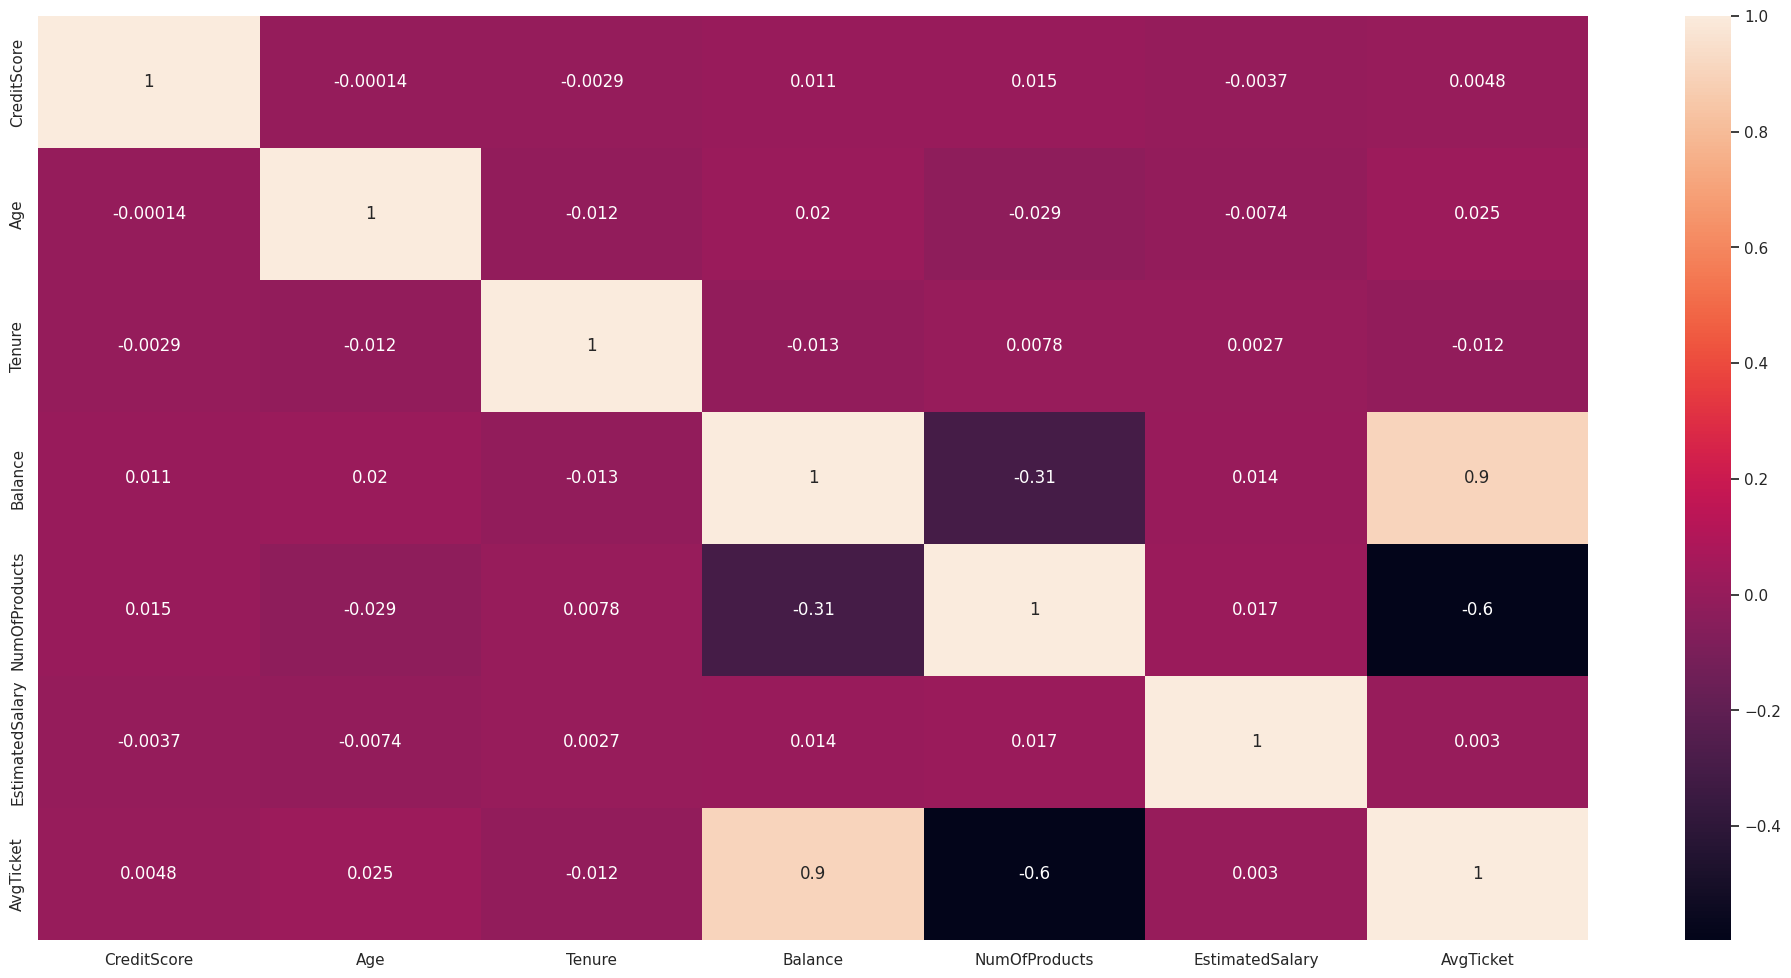

In [38]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2. Categorical Variables

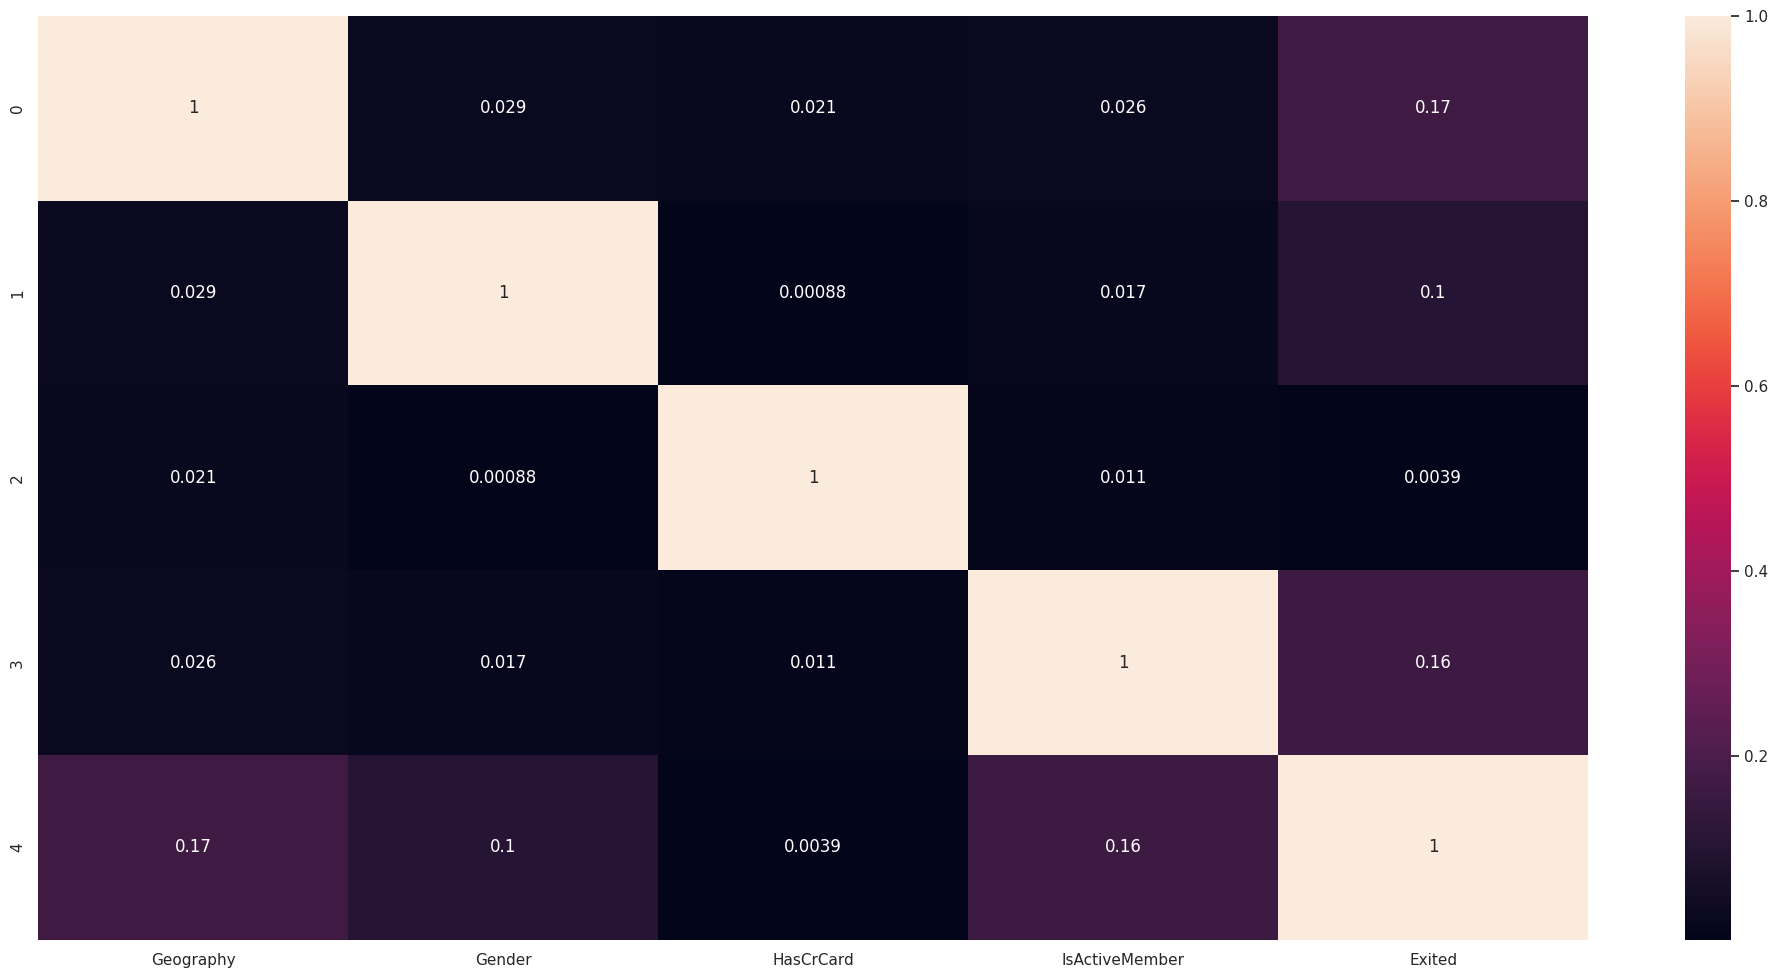

In [39]:
sns.heatmap(pd.DataFrame(corr_cramer_v(cat_attributes)), annot=True);

# 5.0. DATA PREPARATION

In [40]:
df5 = df4.copy()

# drop customer id
df5.drop('CustomerId', axis=1, inplace=True)

## 5.1. Standardization

In [41]:
# looking at session 4.1.2, the only feature that resemble a normal distribution is CredictScore
ss = pp.StandardScaler()

df5['CreditScore'] = ss.fit_transform(df5[['CreditScore']].values)
pickle.dump(ss, open('/home/felipe/repos/churn_indi/src/parameters/CreditScoreScaler.pkl', 'wb'))

## 5.2. Rescaling

In [42]:
mm = pp.MinMaxScaler()
rs = pp.RobustScaler()

In [43]:
# Age
df5['Age'] = rs.fit_transform(df5[['Age']].values)
pickle.dump(rs, open('/home/felipe/repos/churn_indi/src/parameters/AgeScaler.pkl', 'wb'))

# Tenure
df5['Tenure'] = mm.fit_transform(df5[['Tenure']].values)
pickle.dump(mm, open('/home/felipe/repos/churn_indi/src/parameters/TenureScaler.pkl', 'wb'))

# Balance
df5['Balance'] = mm.fit_transform(df5[['Balance']].values)
pickle.dump(mm, open('/home/felipe/repos/churn_indi/src/parameters/BalanceScaler.pkl', 'wb'))

# Number of Products
df5['NumOfProducts'] = mm.fit_transform(df5[['NumOfProducts']].values)
pickle.dump(mm, open('/home/felipe/repos/churn_indi/src/parameters/NumOfProductsScaler.pkl', 'wb'))

# Estimated Salary
df5['EstimatedSalary'] = mm.fit_transform(df5[['EstimatedSalary']].values)
pickle.dump(mm, open('/home/felipe/repos/churn_indi/src/parameters/EstimatedSalaryScaler.pkl', 'wb'))

# Average Ticket
df5['AvgTicket'] = mm.fit_transform(df5[['AvgTicket']].values)
pickle.dump(mm, open('/home/felipe/repos/churn_indi/src/parameters/AvgTicketScaler.pkl', 'wb'))

## 5.3. Encoding

In [44]:
# geography - One Hot Encoding
df5 = pd.get_dummies(df5, prefix='Geography', columns=['Geography'], dtype='int64')

# gender- One Hot Encoding
df5 = pd.get_dummies(df5, columns=['Gender'], dtype='int64')

## 5.4. Train and Validation Split

In [45]:
df5.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,AvgTicket,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
385,-0.941293,2.416667,0.9,0.000000,0.000000,1,1,0.079592,0,0.000000,1,0,0,1,0
8929,-0.848235,-0.166667,0.4,0.374394,0.000000,1,0,0.923771,0,0.422619,1,0,0,1,0
4156,-0.476003,0.500000,0.8,0.499561,0.333333,1,0,0.119804,0,0.281955,0,1,0,1,0
3372,0.009968,0.000000,0.4,0.367514,0.000000,0,1,0.988536,1,0.414854,1,0,0,1,0
3166,-0.992992,2.083333,0.4,0.477554,0.000000,0,1,0.217498,1,0.539068,0,1,0,0,1


In [46]:
# split training and validation datasets
X = df5.drop('Exited', axis=1)
y = df5['Exited'].copy()

x_train, x_validation, y_train, y_validation = ms.train_test_split(X, y, test_size=0.2)

# 6.0. FEATURE SELECTION

# 7.0. MACHINE LEARNING MODELING

## 7.1. Logistic Regression - Baseline

In [62]:
# model definition
lr_model = lm.LogisticRegression(random_state=42)

# model training
lr_model.fit(x_train, y_train)

# model prediction
yhat_lr = lr_model.predict(x_validation)

In [63]:
# performance
# calculate metrics
precision = mt.precision_score(y_validation, yhat_lr)
recall = mt.recall_score(y_validation, yhat_lr)
f1_score = mt.f1_score(y_validation, yhat_lr, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.62810
Recall: 0.20652
F1 Score: 0.60126


## 7.2. KNN

In [66]:
# model definition
knn_model = nh.KNeighborsClassifier(n_neighbors=7)

# model training
knn_model.fit(x_train, y_train)

# model prediction 
yhat_knn = knn_model.predict(x_validation)

In [67]:
# performance
# calculate metrics
precision = mt.precision_score(y_validation, yhat_knn)
recall = mt.recall_score(y_validation, yhat_knn)
f1_score = mt.f1_score(y_validation, yhat_knn, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.64052
Recall: 0.26630
F1 Score: 0.63532


## 7.3. Gradient Boosting

In [68]:
## model definition
gdr_model = en.GradientBoostingClassifier(n_estimators=100, random_state=42)

# model training
gdr_model.fit(x_train, y_train)

# model prediction
yhat_gdr = gdr_model.predict(x_validation)

In [69]:
# performance
# calculate metrics
precision = mt.precision_score(y_validation, yhat_gdr)
recall = mt.recall_score(y_validation, yhat_gdr)
f1_score = mt.f1_score(y_validation, yhat_gdr, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.81429
Recall: 0.46467
F1 Score: 0.75680


## 7.4. Random Forest

In [70]:
# model definition
rf_model = en.RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=None)

# model training
rf_model.fit(x_train, y_train)

# model prediction
yhat_rf = rf_model.predict(x_validation)

In [71]:
# performance
# calculate metrics
precision = mt.precision_score(y_validation, yhat_rf)
recall = mt.recall_score(y_validation, yhat_rf)
f1_score = mt.f1_score(y_validation, yhat_rf, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.81364
Recall: 0.48641
F1 Score: 0.76624


## 7.5. XGBoost

In [58]:
# model definition
xgb_model = XGBClassifier()

# model training
xgb_model.fit(x_train,y_train.values.ravel())

# model prediction
yhat_xgb = xgb_model.predict(x_validation)

In [59]:
# calculate metrics
precision = mt.precision_score(y_validation, yhat_xgb)
recall = mt.recall_score(y_validation, yhat_xgb)
f1_score = mt.f1_score(y_validation, yhat_xgb, average='macro')

# print results
print('Precision: {:.5f}'.format(precision))
print('Recall: {:.5f}'.format(recall))
print('F1 Score: {:.5f}'.format(f1_score))

Precision: 0.72984
Recall: 0.49185
F1 Score: 0.75127


# 8.0. HYPERPARAMETER FINE TUNING

# 9.0. MODEL PERFORMANCE